# Fitness MCMC Documentation Notebook

In [1]:
#Standard Imports
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.integrate import odeint

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Imports from fitness mcmc package 
import fitness_mcmc
import fitness_mcmc.data_io as io 
import fitness_mcmc.fitness_mcmc as m

In [3]:
"""
Loading data and looking at the first 40 ordered genotypes. 
"""
data, time, ordered_frequencies  = io.load_data('filtered_counts_ypd_temp_30.txt')
data

,BC,5,10,25,40,45
0,GGGAGACCGCCGCGGG_AGACGACGGGTATTAC,1682,1101,416,112,41
1,TTATGAAGTAGTTGTA_AATTTTTTTGCCATTC,463,169,50,3,7
2,ATACAATCATTCATAG_CCCGTGAGCTGAGCCG,1375,322,148,120,36
3,GGGTAATCACGCCGAA_GGCAACTAATAATATA,639,256,151,64,31
4,TAGAACCGGTTAAAAA_TGGTAGCTGGACGACA,917,231,48,5,15
...,...,...,...,...,...,...
718,CCAAACGCCGTACTAT_CGTCTAGCATAAAGCA,231,106,21,2,0
719,ACCGCCTGGTCACCAG_TTCGTTACTGCCGGGG,278,111,9,5,0
720,TACAACGGATTGGGAA_TTCACATCTGGTACCA,833,181,89,43,47
721,ACGCACCAAGCCGGGA_CCGGGCGATCCACGAA,2916,1559,334,98,47


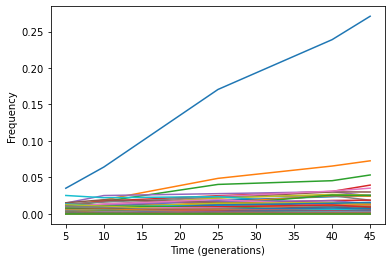

In [4]:
plt.plot([5,10,25,40,45],ordered_frequencies.T);
plt.xlabel('Time (generations)')
plt.ylabel('Frequency')
plt.show()

In [5]:
def growth_numpy(f, t, s):
    df = f * (s - np.sum(f * s))
    return df

In [6]:
times = np.arange(0, 49, 0.1)
f0 = np.random.random(10)
f0 = f0 / sum(f0)
s = np.random.random(10) / 10


In [7]:
f_true = odeint(growth_numpy, t=times, y0=f0, args=(s,), rtol=1e-8)

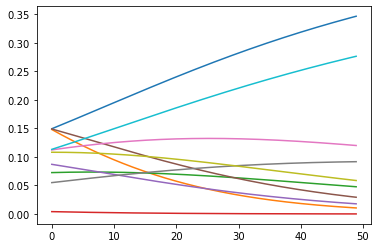

In [8]:
plt.figure()
plt.plot(times, f_true)
plt.show()

In [20]:
N = len(f_true[0])

N = 2

def growth(f, t, s):
    df = f[0:N] * s[0] #- pm.math.sum(s[0] * f[:N]))
    return df

growth_model = pm.ode.DifferentialEquation(
    func=growth,
    times=np.arange(0.1, 49, 0.1),
    n_states=N,
    n_theta=N,
    t0=0,   
)

with pm.Model() as model:
    s_ref = pm.math.constant(0, ndim=1)
    mu = pm.Flat("mu")
    sigma = pm.HalfFlat("sigma")
    s = pm.Normal("s", mu, sigma, shape = (N - 1))
    s_all = pm.math.concatenate((s_ref, s))
    
    f0 = pm.Dirichlet("f0", a = np.ones(N))
    
    growth_curves = growth_model(y0 = f0, theta = s)
    

AssertionError: theano.tensor.jacobian expects a 1 dimensional variable as `expression`. If not use flatten to make it a vector